In [3628]:
# This notebook assumes you have the following installed: 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

<div style="background: linear-gradient(to right, #3c3c3c, #6e6e6e); color:white; padding:10px; border-radius:10px; font-size:24px; text-align:center;">
    Assignment #2 - Shallow Models Training, Validation and Tuning
</div>


# <font color='#3c3c3c'>Task 1 - EDA</font>

In [3629]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


First thing I will do is use info() to know the size of the dataset and maybe additional useful information. 

In [3630]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


 This dataset is much larger that the one in assignment #1, it has 17379 entries.. This means that we can split it like before 70/30/30 or do it more drastically with 60/20/20 since there is more data and we will still be retaining enough data in each subset for reliable training and evaluation. A larger dataset also means that their is more data, which means more diversity, which leads to the model learning more generalizable relationships. Aditionally, the results also confirm that there will be no need for data imputation since there are no missing values. 

Before deciding what to do for the EDA task I want to take a look at the chart the professor provided with a summary of the dataset. This way, we can better understand our dataset; specifically the variables and type of data that we have.

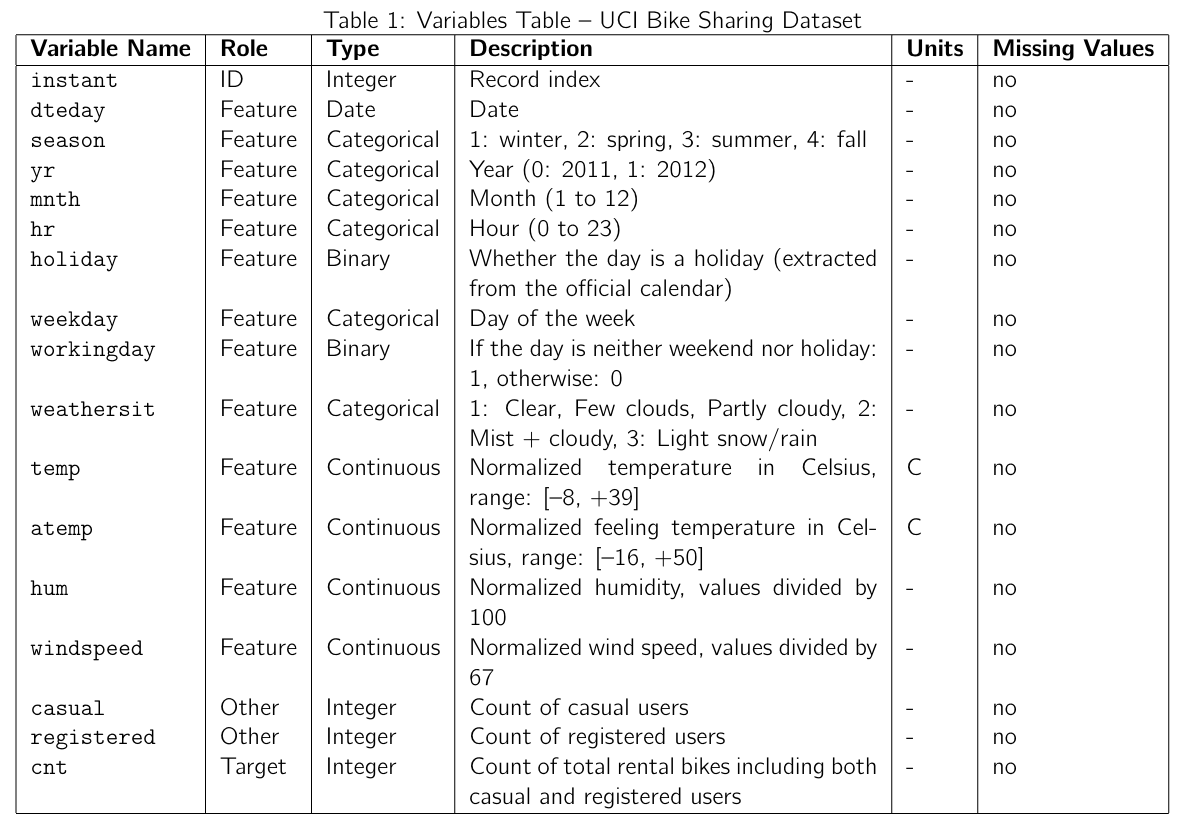

In [3631]:
from IPython import display
display.Image("info.png")

Based on the dataset, there are 16 columns, including the target variable (cnt). Three columns (instant, casual, and registered) are labeled as 'other' or 'ID', meaning they are not true features, leaving us with 13 actual features:

- 4 are continuous (temp, atemp, hum, windspeed).
- 6 are categorical (season, yr, mnth, hr, weekday, weathersit).
- 2 are binary (holiday, workingday).
- 1 is a date (dteday).
It also nice to know right off the bat that there are no missing values in the dataset, which means that no data imputation will be required. 

Additionally, analyzing the descriptions of the columns, there are a few that are redundant or simply don't provide any helpful information. I am considering dropping the following columns: 

- instant: The ID is useless, it is just an index. 
- dteday: The date is not relevant since we are given the "category" of the day in other columns, which is what really matters.
- holiday, weekday, workingday: These three seem to be redundant. I wonder if it is possible to choose only one or 2 and drop the rest.
- casual and registered: I can keep one since it will tell me what the other one is, or I can remove it since it is irrelevant to our objective (Prediction of bike rental count hourly based on the environmental and seasonal settings)

To make sure that I make the best decision, I will have to further analyze a few of them to get to a conclusion.

First, we have to take to take a look at the distribution of the target variable to better understand its shape and check for outliers. 

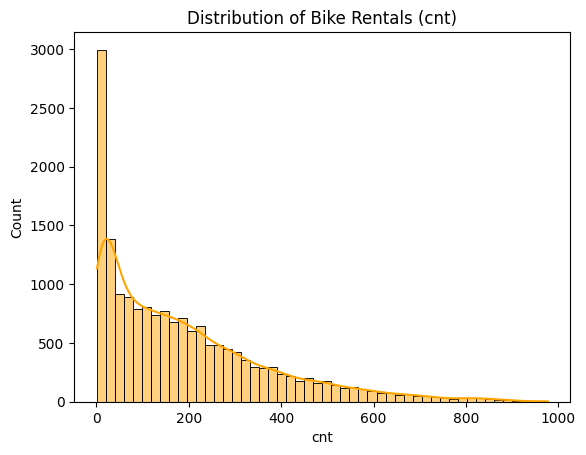

Skewness: 1.2774116037490577


In [3632]:
sns.histplot(df['cnt'], kde=True, bins=50, color='orange')
plt.title('Distribution of Bike Rentals (cnt)')
plt.show()

print("Skewness:", df['cnt'].skew())


The graph and the skewness value (1.28) indicate that the target variable is right-skewed. This suggests that a linear model may perform poorly, as it might struggle to capture the underlying distribution. In theory, we would need to apply a transformation to make the distribution more symmetric if we want to use a linear model effectively. However, other models exist that can handle the skewness well (more robust) without sacrificing generalization (I will elaborate on this later). This also means that we're gonna have to be careful in the splitting process so that all sets are representative of the full range of data points to avoid bias. 

*After a few performance trials...*

I have decided to revisit my splitting strategy. I suspect that the patterns the model learns differ between 2011 and 2012. So far, I've been training on 2011 and validating on 2012, and the model has consistently performed much worse in validation. Despite trying several strategies to improve performance, the improvements have been minimal. To confirm this, I will print the distributions for both years and compare them.

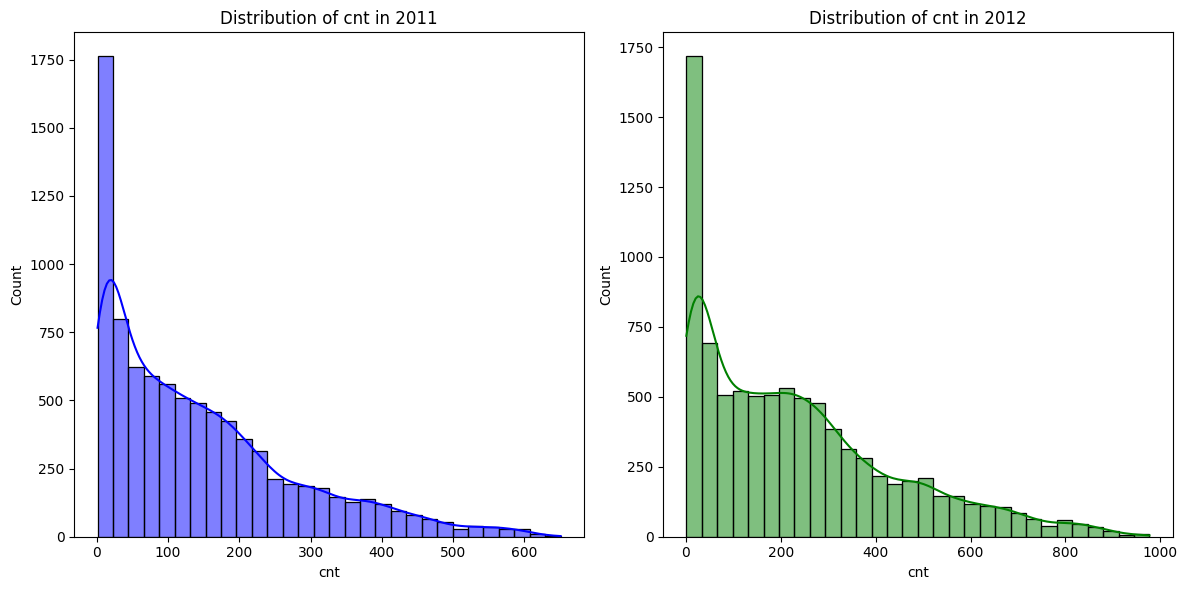

In [3633]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 2011 and 2012 based on 'yr' column
df_2011 = df[df['yr'] == 0]
df_2012 = df[df['yr'] == 1]

# Plot distribution for 2011
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_2011['cnt'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of cnt in 2011')

# Plot distribution for 2012
plt.subplot(1, 2, 2)
sns.histplot(df_2012['cnt'], kde=True, color='orange', bins=30)
plt.title('Distribution of cnt in 2012')

plt.tight_layout()
plt.show()


As suspected, the data in 2012 appears to be much more spread out. Rentals in 2011 range from 0 to around 600, while in 2012, they span from 0 to around 1000. This suggests that my model has been struggling to learn the higher rental values, particularly during peak hours. To address this, I will change my splitting strategy, which I will discuss further in the 'Data Splitting' section.

### <font color='6e6e6e'>Temporal Features</font>

Now, let's move to analyzing the relationship between the target and other variables. It is important to see these relationships not only for correlation, but becuase we have a few temporal variables which may affect our target variable significantly.

- **hr**: Important to analyze because rentals are definitely affected by the time of the day and this will reveal interesting patterns such as peak hours.

- **weekday**: Rentals are probably also affected by the day of the week (weekday or weekend). It will reveal if rentals are more common for trips on the weekend or for transportation to work/school in weekdays. 

- **mnth**: Again, the month will probably have an impact on rentals since maybe during the colder months rentals decrease while in warmer months they probably increase.

- **season**: Directly related to the month, as seasons (spring, summer, fall, winter) are determined by the month. 

**Quick note**: the code for the graphs were generated by ChatGPT. I gave it the variable names, the name of the dataset, and stated what type of graphs I wanted for each. 

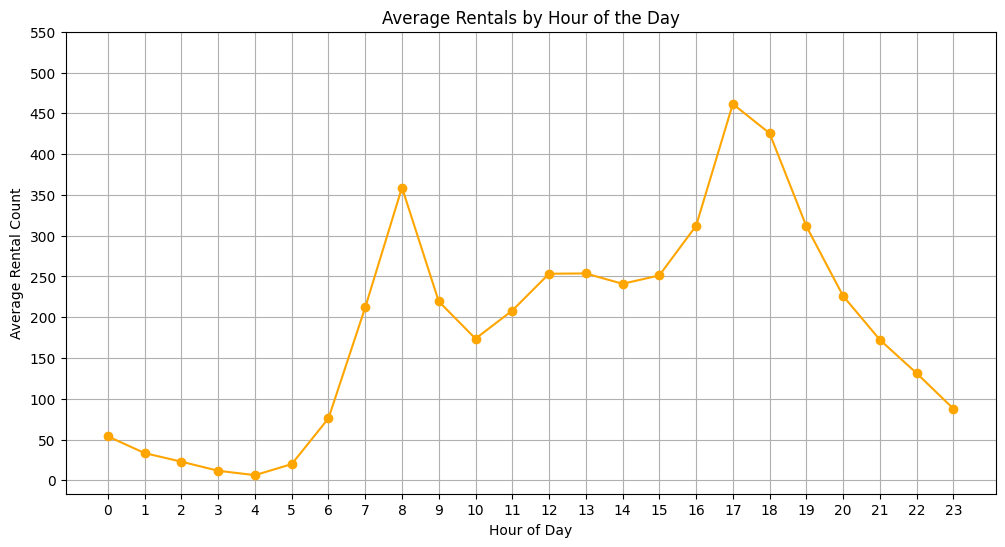

In [3634]:
### RENTALS BY HOUR ###

plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hr')['cnt'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='orange')
plt.title('Average Rentals by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rental Count')
plt.grid(True)

plt.xticks(range(0, 24)) 
plt.yticks(np.arange(0, hourly_avg.max() + 100, 50)) 

plt.show()

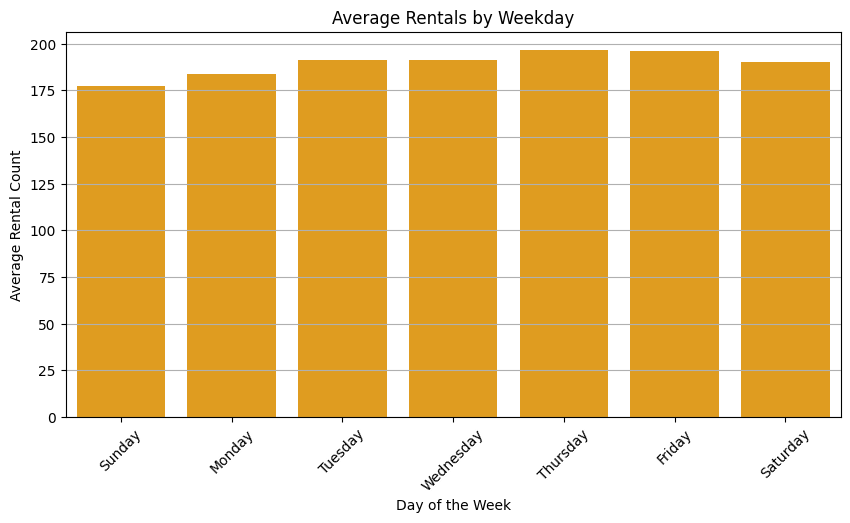

In [3635]:
### RENTALS BY WEEKDAY ###

df_copy = df.copy()  # Create a copy of the original df
df_copy['weekday'] = df_copy['weekday'].map({
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
    4: 'Thursday', 5: 'Friday', 6: 'Saturday'
})

plt.figure(figsize=(10, 5))
weekday_avg = df_copy.groupby('weekday')['cnt'].mean().reindex([
    'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'
])
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, color='orange')
plt.title('Average Rentals by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rental Count')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


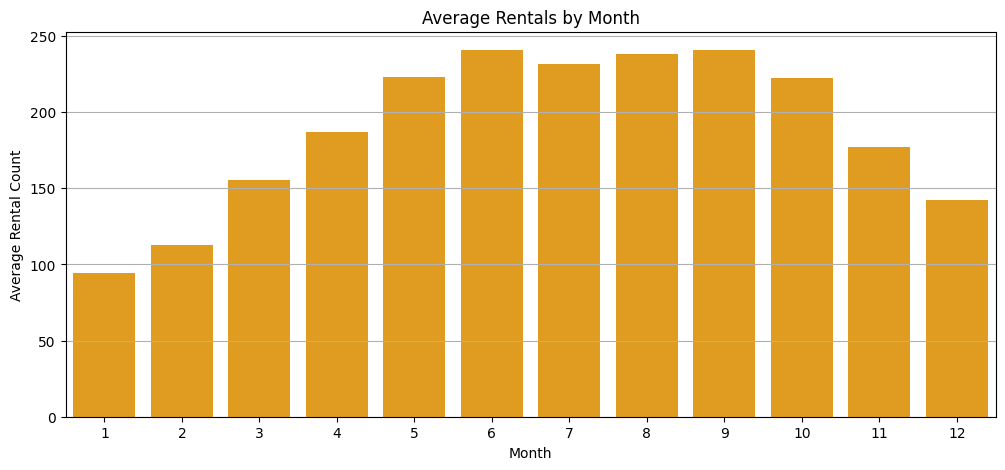

In [3636]:
### RENTALS BY MONTH ###

plt.figure(figsize=(12, 5))
month_avg = df.groupby('mnth')['cnt'].mean()
sns.barplot(x=month_avg.index, y=month_avg.values, color='orange')
plt.title('Average Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Rental Count')
plt.grid(True, axis='y')
plt.show()


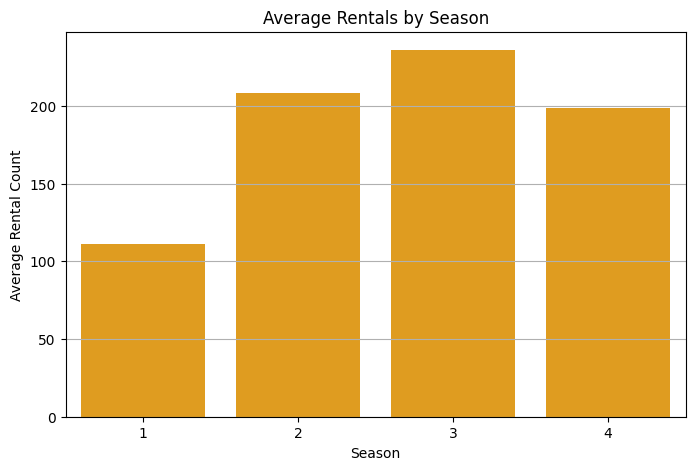

In [3637]:
### RENTALS BY SEASON ###

plt.figure(figsize=(8, 5))
season_avg = df.groupby('season')['cnt'].mean()
sns.barplot(x=season_avg.index, y=season_avg.values, color='orange')
plt.title('Average Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Average Rental Count')
plt.grid(True, axis='y')
plt.show()

**Conclusion on relationships**

- **Rentals by hours**: The graph reveals two peak hours for rentals: one at 8 AM and another at 5 PM. At 8 AM, rentals reach approximately 360, and at 5 PM, they peak at around 465 rentals. The graph also shows that 4 AM experiences the lowest rentals, which gradually increase until 8 AM, where rentals peak. After 8 AM, there is a dip in rentals until 10 AM, followed by a steady increase reaching 250 rentals per hour between 12 PM and 1 PM. Then it reaches the second peak after which rentals significantly drop for the remainder of the evening. The peak hours may be related to the times people go to work 8-9 to the time people go back home 5. So, probably bikes are being rented for commmuting purposes. This is an important feature to predict rentals.

- **Rentals by Weekday**: The graph indicates that there is no significant variation in rental counts across the days of the week. The average rentals per day range from approximately 180 to 200, suggesting that weekday doesn't have an really have an influence. This is contradicts the assumption about rentals being for commuting. If that was the case, then weekdays would have higher amount of rentals than weekends. The graph shows that people are equally likely to rent bikes during weekdays as they are on weekend, therefore it could be potentially dropped. 

- **Rentals by Month**: The bar plot show a visible effect on rentals. The month with the least amount of average rentals is January, while the months with the highest average are June and September. The results are intuitive since at the beginning of the year rentals are low and they start increasing through the months as the weather get warmer. The gradual increase in rentals from January to June aligns with the warmer seasons, suggesting that weather or temperature is a strong determinant of rental behavior. Rentals appear to be stable in June and September, with a sharp drop in October, likely due to winter starting.

- **Rentals by Season**: As expected, summer has the highest average rentals, with over 200 rentals per day on average, while winter has the lowest, at around 105 rentals per day on average. Spring and fall have similar averages, ranging between 200 and 210 rentals, indicating that people tend to rent bikes more during the warmer seasons. Since season is derived from month, it may be a good idea to drop season to reduce redundancy. 


### <font color='6e6e6e'>Binary Features</font>

Now I will move on to analyze the reltionship between the target value and the binary features: workingday and holiday. 

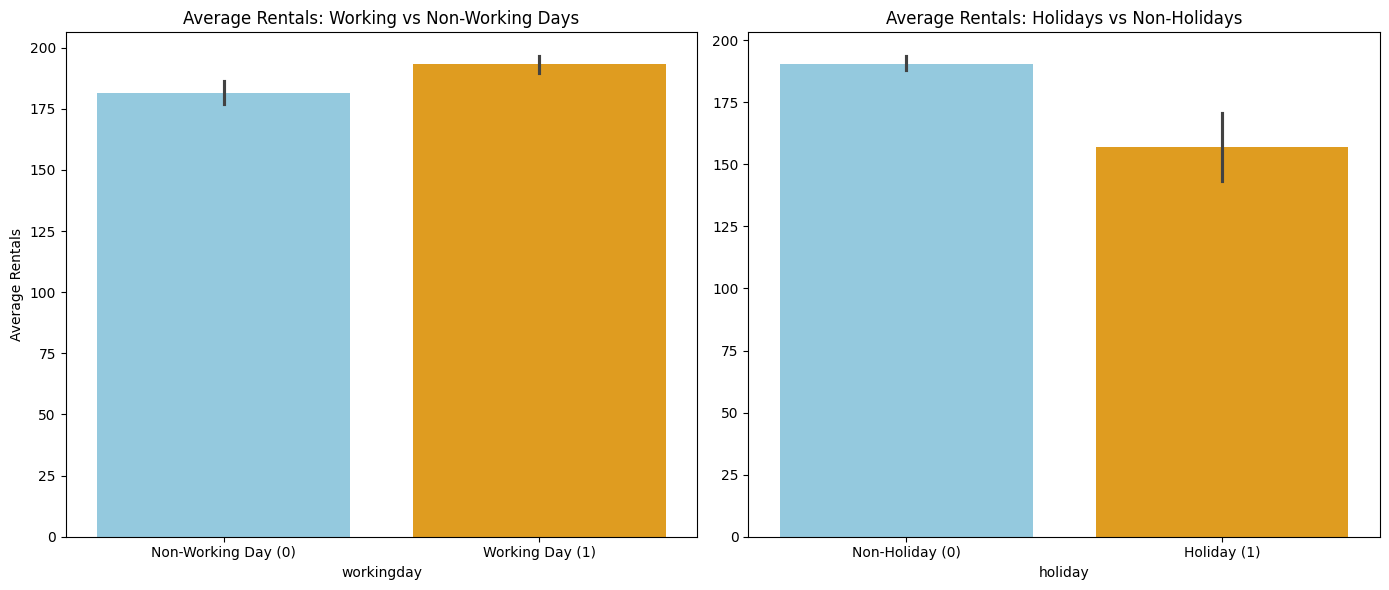

In [3638]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: workingday vs cnt
sns.barplot(x='workingday', y='cnt', hue='workingday', data=df, ax=axes[0],
            palette={0: 'skyblue', 1: 'orange'}, legend=False)
axes[0].set_title('Average Rentals: Working vs Non-Working Days')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Working Day (0)', 'Working Day (1)'])
axes[0].set_ylabel('Average Rentals')

# Plot 2: holiday vs cnt
sns.barplot(x='holiday', y='cnt', hue='holiday', data=df, ax=axes[1],
            palette={0: 'skyblue', 1: 'orange'}, legend=False)
axes[1].set_title('Average Rentals: Holidays vs Non-Holidays')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Holiday (0)', 'Holiday (1)'])
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


The results show a very weak relationship between cnt and workingday. Eventhough rentals increase during working days, the average only increaes by around 15. The relationship between cnt and holiday is a bit more visible, but I still don't think is a major discovery. Rentals on holidays seem to decrease from ~185 on non-holidays to ~152 on holidays. 
The analysis reveals a very weak relationship between the target variable (cnt) and the binary feature workingday. Although the average number of rentals is slightly higher on working days, the difference is minimal, increasing by only around 15 rentals.
In contrast, the relationship between cnt and holiday is slightly more noticeable. The average number of rentals drops from approximately 185 on non-holidays to 152 on holidays, indicating a slight decrease in bike usage during public holidays. However, even this change doesnt seem to strongly influence the overall model. 

While workingday and holiday do not show strong individual correlations with the target variable cnt, it may still be valuable to keep them during model training, especially in combination with other features like hour, weekday, or season. For example, bike rental behavior might change on working days at certain hours, even if the overall daily average doesn’t show a large difference. This could become more visible through interactions in more advanced models. I will keep both for now and contnue analyzing them.

### <font color='6e6e6e'>Weather-Related Features</font>

Finally, I will analyze the relationship between cnt and the last set of features, weather-related features. These are important features since the objective of our model is to predict rentals based on environmental settings as well. 

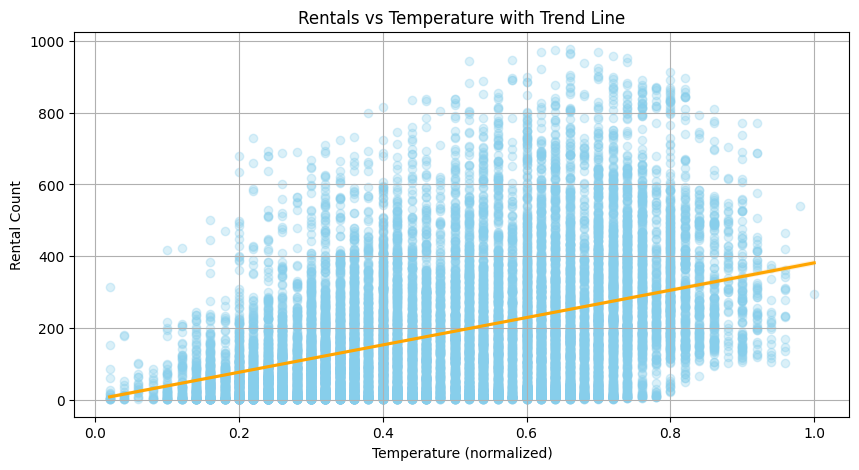

In [3639]:
## RENTALS VS TEMP  ##
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='temp', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'},color='skyblue' )
plt.title('Rentals vs Temperature with Trend Line')
plt.xlabel('Temperature (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

The scatter plot between temperature (temp) and bike rental count (cnt) clearly shows a positive linear relationship. As temperature increases, the rental count tends to rise as well, which is expected since warmer weather generally encourages more outdoor activities. However, there is a noticeable slight decrease in rental density as the normalized temperature surpasses a value of 0.8. This suggests that as temperatures approach higher, potentially uncomfortable levels, fewer people rent bikes. This could indicate that beyond a certain point, the heat becomes less favorable for biking (which we know it does), which may explain the dip in rental activity.

Additionally, the scatter plot shows vertical clustering of points at certain temperature values, indicating that the temperature data in the dataset was likely recorded at regular intervals. This pattern suggests a consistent, periodic collection of temperature readings.

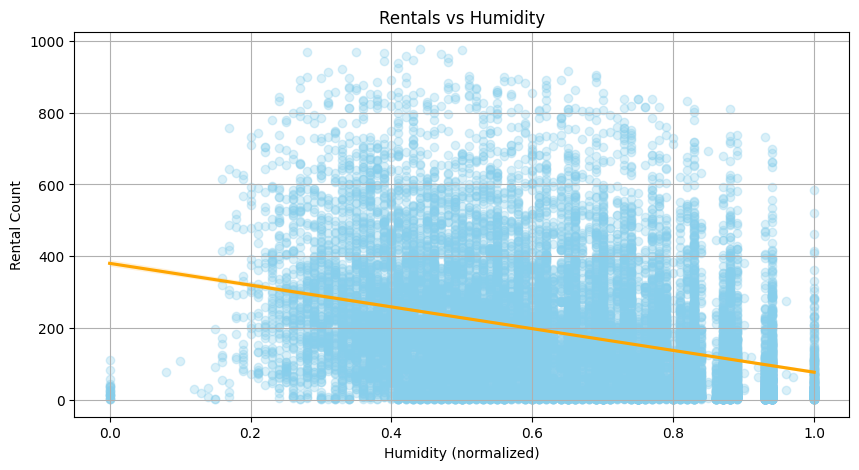

In [3692]:
## RENTALS VS HUMIDITY  ##

plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='hum', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'},color='skyblue' )
plt.title('Rentals vs Humidity')
plt.xlabel('Humidity (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

The scatter plot is a difficult to analyze because of the significant variance at each humidity point. However, despite the noise, the trend line indicates a weak negative relationship between humidity and rental count.  This makes sense becasue as humidity increases it becomes more and more uncomfortable to drive a bike which of course means less rentals. It is instresting though, the lack of density in the normalized humidity values between 0 and 0.2. This could suggest that very low humidity (likely associated with colder weather) is rare in the dataset. It might also indicate that in these conditions, people may be less inclined to rent bikes due to the colder temperatures, further supporting the idea that extreme cold, rather than humidity alone, may also discourage bike rentals.

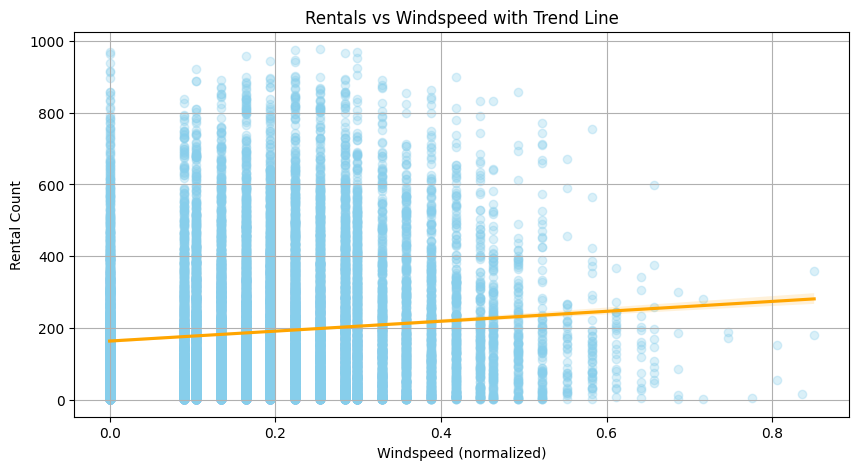

In [3641]:
## RENTALS VS WINSPEED ##
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x='windspeed', y='cnt', scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'}, color='skyblue')
plt.title('Rentals vs Windspeed with Trend Line')
plt.xlabel('Windspeed (normalized)')
plt.ylabel('Rental Count')
plt.grid(True)
plt.show()

Unlike temperature and humidity, the orange trend line in this graph suggests a very weak positive correlation between windspeed and rentals,  which might seem counterintuitive. However, the trend is so faint that it’s likely statistically insignificant. This might be due to the fact that most data points are concentrated at lower windspeed levels (see how most points are left of 0.5). 

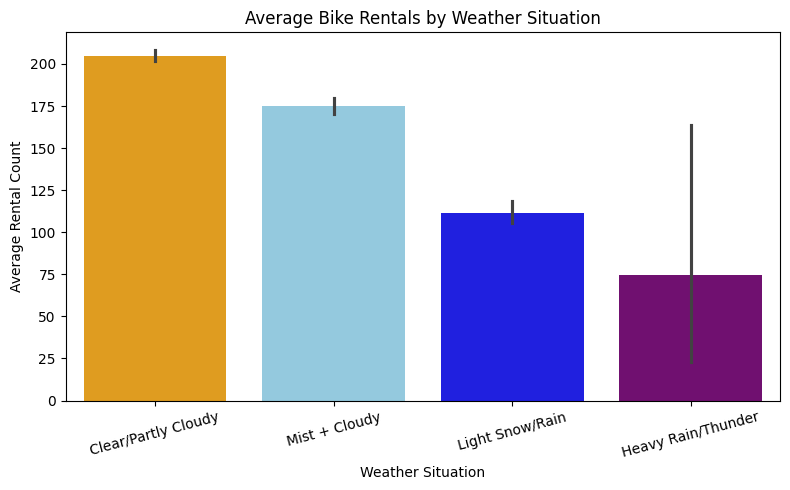

In [3642]:
## RENTALS VS WEATHER SITUATION ##

# Create a copy of the DataFrame to avoid modifying the original one
df_copy = df.copy()

# Map weather situation labels to the copied DataFrame
weather_labels = {
    1: 'Clear/Partly Cloudy',
    2: 'Mist + Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Thunder'
}
df_copy['weather_label'] = df_copy['weathersit'].map(weather_labels)

# Plot the data using the copy
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_copy,  # Use the copied DataFrame
    x='weather_label', 
    y='cnt', 
    hue='weather_label', 
    palette=['orange', 'skyblue', 'blue', 'purple'], 
    legend=False
)

# Customize the plot
plt.title('Average Bike Rentals by Weather Situation')
plt.xlabel('Weather Situation')
plt.ylabel('Average Rental Count')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()



The analysis reveals a strong and clear relationship between weather conditions (weathersit) and the number of bike rentals (cnt). The trend aligns with what we would intuitively expect:

- Clear/Partly Cloudy: This weather condition shows the highest average rentals (around 200). It makes sense that good weather encourages people to rent bikes.

- Mist + Cloudy: Rentals are still fairly high in this category, but there’s a slight drop compared to clear skies (around 175)

- Light Snow/Rain: Weather conditions here cause a noticeable decline in rentals. The average count drops to around 110 rentals.

- Heavy Rain/Thunder: The worst weather condition shows the lowest average rentals, with a significant drop to about 75 rentals.

Overall, this suggests a linear negative relationship: As the weather worsens, the number of bike rentals decreases. 

### <font color='6e6e6e'>Analyzing Outliers</font>

I was going to analyze outliers using a boxplot, but since the data is skewed it doesn't make sense. Instead, I will print a strip plot.

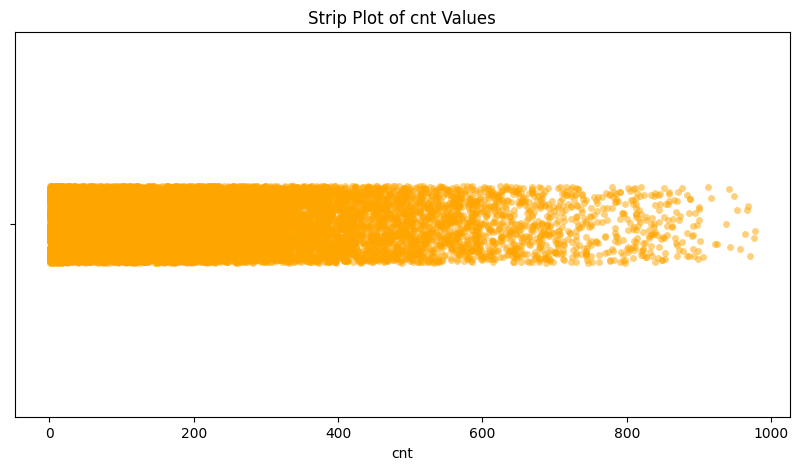

In [3643]:
plt.figure(figsize=(10, 5))
sns.stripplot(x=df["cnt"], jitter=True, alpha=0.5, color='orange')  
plt.title("Strip Plot of cnt Values")
plt.show()


With the strip plot above I wanted to see if I was able to spot any extreme outliers since in the bar plot it was not visible no matter the number of bins I chose. As seen in the bar graph, the distribution is heavily right-skewed, with a high density of lower values and a sharp decrease in frequency as values increase. In the strip plot we can see this more clearly and we can also observe that there are no points that exceed 1000, and there is a noticeable drop in density for values above 900. These could be considered possible outliers, but further analysis is required. 

I will calculate the IQR and print those data points that exceed the upper bound, which will idenitfy extreme outliers. 

In [3644]:
Q1 = df["cnt"].quantile(0.25)
Q3 = df["cnt"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + (2.7 * IQR)  

outliers = df[df["cnt"] > upper_bound]
print(outliers[["instant", "dteday", "cnt", "temp", "hum", "windspeed"]]) 

       instant      dteday  cnt  temp   hum  windspeed
10622    10623  2012-03-23  957  0.72  0.42     0.1642
14293    14294  2012-08-23  941  0.74  0.48     0.2239
14725    14726  2012-09-10  968  0.62  0.35     0.2985
14748    14749  2012-09-11  970  0.70  0.28     0.0000
14773    14774  2012-09-12  977  0.66  0.44     0.2537
14964    14965  2012-09-20  976  0.64  0.50     0.2239
15084    15085  2012-09-25  967  0.66  0.39     0.2836
15108    15109  2012-09-26  953  0.74  0.48     0.2985
15444    15445  2012-10-10  948  0.58  0.43     0.2239
15588    15589  2012-10-16  943  0.52  0.39     0.1940
15756    15757  2012-10-23  938  0.68  0.41     0.0000
15780    15781  2012-10-24  963  0.66  0.47     0.0000


The results show 12 potential outliers, which is a small number considering the size of the dataset (12/17379 = ~0.0007%). I suspect that keeping or removing these 12 points won’t significantly impact the overall distribution so maybe we shouldn't even bother removign these. However, to confirm this, I will plot the distribution with and without the outliers and print the summary statistics to have a clearer understanding of the effect it will have. 

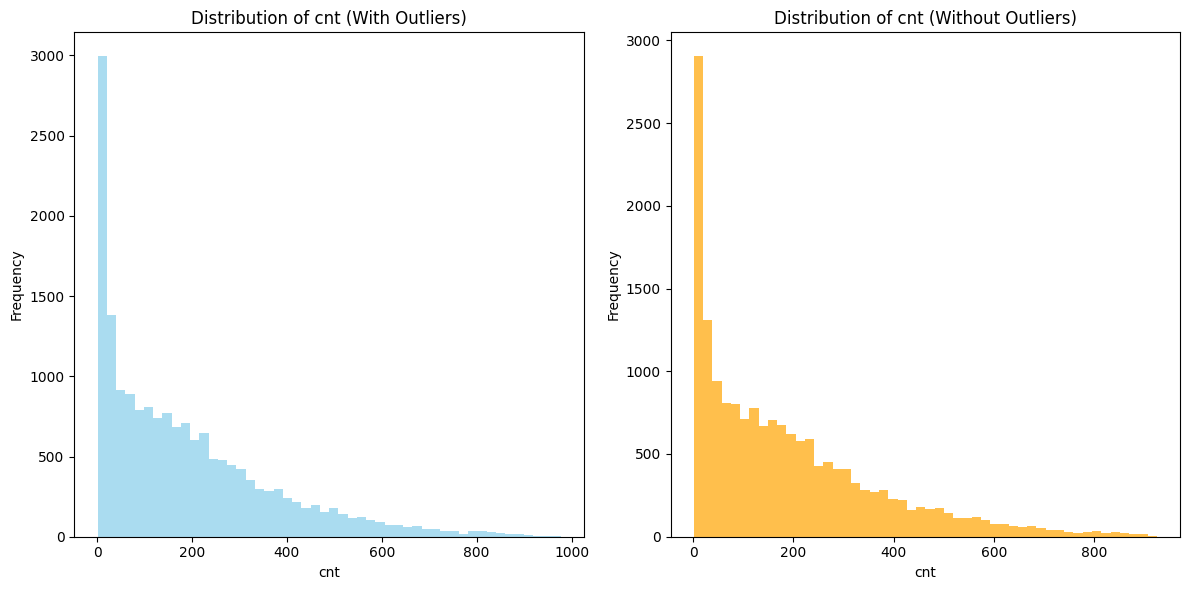

In [3645]:
df_no_outliers = df[df["cnt"] <= upper_bound]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df["cnt"], bins=50, color='skyblue', alpha=0.7)
plt.title("Distribution of cnt (With Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_no_outliers["cnt"], bins=50, color='orange', alpha=0.7)
plt.title("Distribution of cnt (Without Outliers)")
plt.xlabel("cnt")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [3646]:
original_stats = df["cnt"].describe()
cleaned_stats = df_no_outliers["cnt"].describe()

original_mean = df["cnt"].mean()
cleaned_mean = df_no_outliers["cnt"].mean()

original_median = df["cnt"].median()
cleaned_median = df_no_outliers["cnt"].median()

original_std = df["cnt"].std()
cleaned_std = df_no_outliers["cnt"].std()

original_skew = df["cnt"].skew()
cleaned_skew = df_no_outliers["cnt"].skew()

print("Original Data Statistics:")
print(f"Mean: {original_mean}, Median: {original_median}, Std: {original_std}, Skew: {original_skew}")

print("\nCleaned Data Statistics:")
print(f"Mean: {cleaned_mean}, Median: {cleaned_median}, Std: {cleaned_std}, Skew: {cleaned_skew}")


Original Data Statistics:
Mean: 189.46308763450142, Median: 142.0, Std: 181.38759909186473, Skew: 1.2774116037490577

Cleaned Data Statistics:
Mean: 188.93176714458457, Median: 142.0, Std: 180.31974431300907, Skew: 1.2563408640704234


As suspected, the results show minimal impact from keeping or removing the outliers. The mean, median, and standard deviation remain almost unchanged, although there is a slight difference of about 0.02 in skewness, which may suggest that removing the outliers could lead to a slightly more symmetrical distribution. However, I don't believe the impact is significant enough to remove the outliers. I think will keep the outliers.

*After a few days...*

After a few performance trials, I decided to change my mind and remove the outliers to see if it had en effect on performance. I dropped them in the "Feature Engineering"  section.

*Spoiler*: it did improve performance

# <font color='#3c3c3c'>Task 2 - Data Splitting</font>

**First Splitting Strategy Application Description**

For this task, I will initially follow the recommendation in the guidelines to split into 60/20/20, reserving 60% for training, 20% for validation, and 20% for testing. I can change it later on when I can measure the model's performance. But, for now I believe is a solid decision since this dataset is moderately large enough to balance having enough data to effectively train the model while keeping a meaningful portion for unbiased validation and testing sets.

The suggestion on the guidelines to focus on trying to keep the temporal order really threw me off at first. I discussed it with ChatGPT as to how I could do this. It initally suggested "stratification", which at first made sense because it would allow me to split the data based on the temporal features of my choice. Then, when I investigated a bit more about it I realized it wasn't a good choice becuase this splitting strategy was often used for classification models, which is not our case. Then, it suggested to split the data into years; assigning the 2011 entries to the training set and 2012 entries to the validation and test sets. It didn't make much sense in mind that I manually assigned a year to the different sets. I didn't put much thought into it, I rejected almost immediately since it sacrificed randomness. At this point I went back to the guidelines and read through the actual purpose of the model again. I was extremely troubled as to how to split the data keeping the temporal order and keep it randomized at the same time. After much consideration, I realized that maintaining both strict temporal order and randomness simultaneously is fundamentally contradictory: if you shuffle the data, you lose the order; if you preserve the order, you lose randomness. I'm not sure if my logic is correct but given that the model's task is to predict bike rental counts on an HOURLY basis and that the temporal features will be captured later through feature engineering I will split the data as I normaly would, completely randomized. 


**Second Splitting Strategy Application Description**

My model was performing poorly in the linear regression model (R²: 0.50 and MSE: 16307) and much better in random forest(R²: 0.936 and MSE: 2061) and gradient boosting(R²: 0.9437 and MSE: 1828.729). The difference in performance was expected becuase of the complexity of the data that the linear regression was not going to be able to capture. I still don't think this was due to data leakage to be honest, because in mind if there was data leakage the linear regression model would perform much better. Nevertheless, I still have my doubts so I will change the splitting strategy. Instead of sacrificing the order, I will now sacrifice randomness to make sure the temporal order is kept through chronological splitting. I intially tried to split in 60/20/20 again, but the distribution of the dataset was very different between splits, so I decided to first check how many entries there were for 2011 and for 2012, there was around the same amount. So, I decided to assign the 2011 entries to the training set and then divide 50/50 the entries from 2012 between the validation and test sets. This led to a split of around 50/25/25.

**Third Splitting Strategy Application Description**

At this point I was worried. The models were performing terribly and I started to realize that maybe my first strategy was leading to data leakage. I thought that the linear regression couldn't get worse, but I was wrong. The linear regression model only captured around 23% of the data and both random forest and gradient boosting captured 63%. Despite plety of efforts and modification, these values would only change by at most 0.05. I had to stop and re-evaluate everything I have done. Keep in mind, the splitting strategy wasn't in mind to change. It took me a while to understand that maybe the model was doing so poorly on validation than on training becuase it was learning 2011 patterns. This made me suspect that maybe, if the years patterns were so different, then my model would never learn. After going back to EDA to confirm this, I decided to change my strategy one more time. I switched to TimeSeriesSplit. Even though the purpose of the model isn’t to predict the future, I knew that using TimeSeriesSplit would help me preserve the temporal order of the data and still allow me to split the data in a 60/20/20 manner like I originally wanted. This felt like the best way to maintain the integrity of the temporal relationships in the data, which were crucial for predicting bike rentals on an hourly basis. Hopefully, this would improve the performance and lead to more reliable results. 

*Spoiler*: it did improve and I didn't change the strategy anymore.

In [3647]:
X = df.drop(columns=['cnt'])  #
y = df['cnt'] 

split_80_20 = int(len(X) * 0.8)
X_train_val, X_test = X[:split_80_20], X[split_80_20:]
y_train_val, y_test = y[:split_80_20], y[split_80_20:]


split_60_20 = int(len(X_train_val) * 0.75)
X_train, X_val = X_train_val[:split_60_20], X_train_val[split_60_20:]
y_train, y_val = y_train_val[:split_60_20], y_train_val[split_60_20:]
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")


Training set shape: (10427, 16), Validation set shape: (3476, 16), Test set shape: (3476, 16)


I printed the shape of the sets to make sure they were splitted correctly.

- training set →  10427 / 17379 = **59.997698%**
- validation set →  3476/ 17379 = **20.0001151%**
- test set →  3476/ 17379 = **20.0001151%**

# <font color='#3c3c3c'>Task 3 - Feature Engineering</font>

### <font color='6e6e6e'>Before encoding and transformations</font>

Now that I have a much clearer understanding of the data and its relationships, and with the data split, the next step is to decide which columns to drop. To make this decision, I will first check for outliers and then generate a correlation heatmap to identify any redundant or highly correlated features.

In [3648]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 2.7 * IQR
mask = y_train <= upper_bound

X_train = X_train[mask]
y_train = y_train[mask]


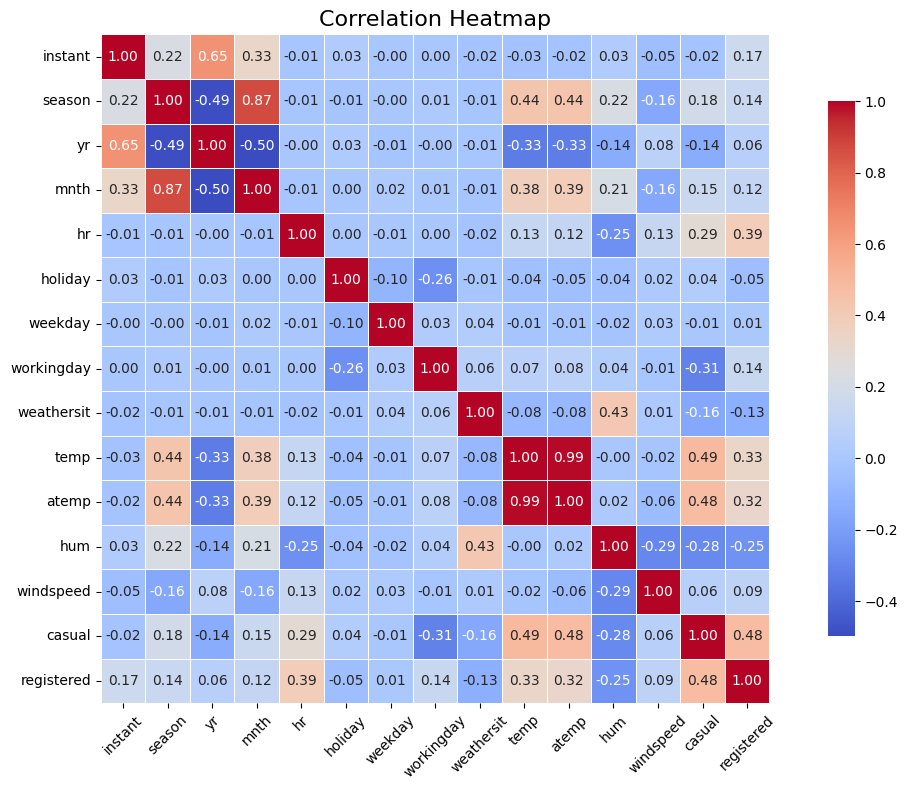

In [3649]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr(numeric_only=True)

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

There were a few columns that we knew from the beginning that we would drop: 
- instant
- dteday
- casual
- registered

The heatmap doesn't show the following correlations anymore because cnt was dropped already. Nevertheless, I printed a heatmap before and recorded the high correlation values: 
- registered with 0.97 → Given this high correlation, I will definitely drop it.
- casual with of 0.69 → I was already considering removing it, so it will be dropped as well.

The heatmap also highlights some strong correlations between features:
- atemp and temp with 0.99 → This makes sense since the felt temperature is very similar to the actual one. I will drop atemp to remove redundancy. 
- month and season with 0.87 → As suspected, season is derived from month so they are redundant. I will keep month. 

In conclusion, I will go ahead and drop instant, dteday, casual, registered, atemp, season

In [3650]:
drop_cols = ['instant', 'dteday', 'casual', 'registered', 'atemp', 'season']
X_train = X_train.drop(columns=drop_cols)
X_val = X_val.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

After dropping the strongly correlated variables identified earlier, I generated a new heatmap. As seen below, no remaining features exhibit strong correlations with each other or with the target variable. While the map does show a moderate negative correlation between yr (year) and mnth (month), I have decided not to remove either feature, as I believe both provide valuable information. This confirms that the dataset is now cleaner, with minimal redundancy and reduced risk of multicollinearity

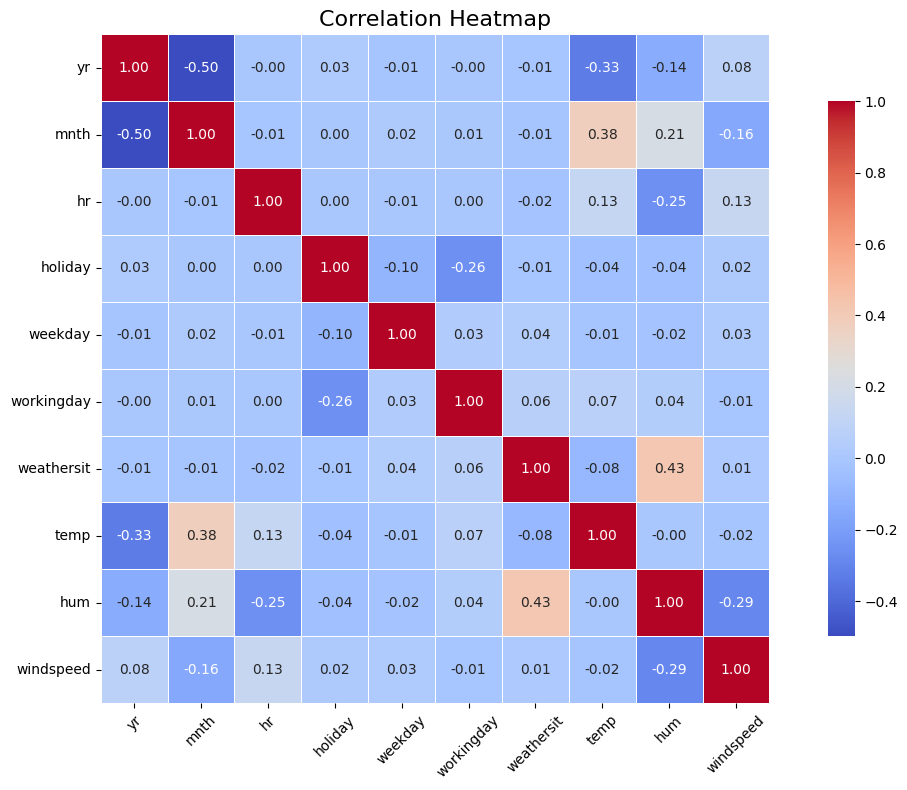

In [3651]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr(numeric_only=True)

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Before starting with the encoding process, I  want to print the current features present in the dataset. This way I will not forget to encode any feature.

In [3652]:
# Check the datatypes of the training set features
print("Training set datatypes:")
print(X_train.dtypes)

# Optional: peek at first few rows for more clarity
X_train.head()

Training set datatypes:
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
dtype: object


,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,0,1,0,0,6,0,1,0.24,0.81,0.0
1,0,1,1,0,6,0,1,0.22,0.80,0.0
2,0,1,2,0,6,0,1,0.22,0.80,0.0
3,0,1,3,0,6,0,1,0.24,0.75,0.0
4,0,1,4,0,6,0,1,0.24,0.75,0.0


Now that we can see the features that are still on our dataset, I will proceed to list what encoding strategy I will use for each one: 
- **yr** → stays the same

- **mnth** → Initially planned for **one-hot encoding** since it's a categorical feature representing months (1–12). This would allow the model to treat each month as a separate category, preventing it from accessing future months' data. **However**, after a few performance trials, I have decided not to encode mnth, as it unnecessarily increases the number of features, and it can simply remain as it is.

- **hr** → **sine and cosine transformation** because hours are cyclical (0–23), meaning 23:00 and 00:00 are conceptually close, and sine and cosine transforms preserve this cyclical nature or order

- **holida**y → stays the same because it's binary

- **weekday** → **sine and cosine transformation**  because even though it is categorical, Monday to Sunday, there is an important order to mantian since some days are closer to others.

- **workingday** → stays the same because it's already binary 

- **weathersit** → **one-hot encoding** because it's categorical representing different weather situations 

- **temp** → **scaling** because it's a continuous feature representing the different degrees in temperature. Scaling will normalize the data and make sure the model treats it correctly.

- **hum** → **scaling** because it's a continuous feature representing humidity, and scaling will allow the model to handle it with no issues

- **windspeed** → **scaling** because it's a continuous feature representing wind speed. Again, this will allow the model to treat it accordingly

### <font color='6e6e6e'>Encoding</font>

Now, we can move on to the encoding process.

In [3653]:
def encode_cyclical(df, column):
    max_val = df[column].max()
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    df.drop(columns=[column], inplace=True)
    return df

for col in ['hr', 'weekday']:
    X_train = encode_cyclical(X_train, col)
    X_val = encode_cyclical(X_val, col)
    X_test = encode_cyclical(X_test, col)

In [3654]:
# Here i am just checking that the original column is gone and that there are four new columns
X_train.head()

,yr,mnth,holiday,workingday,weathersit,temp,hum,windspeed,hr_sin,hr_cos,weekday_sin,weekday_cos
0,0,1,0,0,1,0.24,0.81,0.0,0.000000,1.000000,-2.449294e-16,1.0
1,0,1,0,0,1,0.22,0.80,0.0,0.269797,0.962917,-2.449294e-16,1.0
2,0,1,0,0,1,0.22,0.80,0.0,0.519584,0.854419,-2.449294e-16,1.0
3,0,1,0,0,1,0.24,0.75,0.0,0.730836,0.682553,-2.449294e-16,1.0
4,0,1,0,0,1,0.24,0.75,0.0,0.887885,0.460065,-2.449294e-16,1.0


In [3655]:
onehot_cols = ['weathersit']

X_train = pd.get_dummies(X_train, columns=onehot_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=onehot_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=onehot_cols, drop_first=True)

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [3656]:
X_train.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,hr_sin,hr_cos,weekday_sin,weekday_cos,weathersit_2,weathersit_3,weathersit_4
0,0,1,0,0,0.24,0.81,0.0,0.000000,1.000000,-2.449294e-16,1.0,False,False,False
1,0,1,0,0,0.22,0.80,0.0,0.269797,0.962917,-2.449294e-16,1.0,False,False,False
2,0,1,0,0,0.22,0.80,0.0,0.519584,0.854419,-2.449294e-16,1.0,False,False,False
3,0,1,0,0,0.24,0.75,0.0,0.730836,0.682553,-2.449294e-16,1.0,False,False,False
4,0,1,0,0,0.24,0.75,0.0,0.887885,0.460065,-2.449294e-16,1.0,False,False,False


In [3657]:
scale_cols = ['temp', 'hum', 'windspeed']
scaler = StandardScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])


In [3658]:
# Here I am just checking that the scalar was applied to the correct columns
X_train.head()

,yr,mnth,holiday,workingday,temp,hum,windspeed,hr_sin,hr_cos,weekday_sin,weekday_cos,weathersit_2,weathersit_3,weathersit_4
0,0,1,0,0,-1.112626,0.906471,-1.556124,0.000000,1.000000,-2.449294e-16,1.0,False,False,False
1,0,1,0,0,-1.213962,0.855892,-1.556124,0.269797,0.962917,-2.449294e-16,1.0,False,False,False
2,0,1,0,0,-1.213962,0.855892,-1.556124,0.519584,0.854419,-2.449294e-16,1.0,False,False,False
3,0,1,0,0,-1.112626,0.602997,-1.556124,0.730836,0.682553,-2.449294e-16,1.0,False,False,False
4,0,1,0,0,-1.112626,0.602997,-1.556124,0.887885,0.460065,-2.449294e-16,1.0,False,False,False


After a lot of refinement and tweaking, I was able to get the model to perform well, achieving an R² score of 83 on the validation set. However, I was in a point were the models wouldn't perform any better no matter what I did. So after some examination on the performance of the mdoels I realized that my model was struggling to predict higher rental counts accurately, especially during peak times when the values tend to be much larger. I suspected that the right-skewed nature of the cnt variable (the target) was causing this issue, as the model was likely being overly influenced by the majority of smaller values, while failing to capture the patterns in the larger, more extreme values. To address this, I decided to apply a log1p transformation to the target variable (cnt). This transformation helps to compress the scale of larger values, reduce the influence of extreme outliers, and normalize the distribution, making it easier for the model to learn. 

In [3659]:
y_train = np.log1p(y_train)  
y_val = np.log1p(y_val)  
y_test = np.log1p(y_test)  


*Spoiler*: it did improve performance

### <font color='6e6e6e'>After encoding</font>

I want to check if there are any interaction terms I can create, so I will start by using the Variance Inflation Factor (VIF) to identify variables with high multicollinearity. 

In [3660]:
X = X_train.select_dtypes(include=[float, int])

X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

X_vif = add_constant(X)

# VIF for each feature 
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


        feature        VIF
0         const  12.539541
1            yr   1.380261
2          mnth   1.497830
3       holiday   1.127955
4    workingday   2.407497
5          temp   1.283613
6           hum   1.347676
7     windspeed   1.132576
8        hr_sin   1.234568
9        hr_cos   1.080326
10  weekday_sin   1.019706
11  weekday_cos   2.268241


Based on the VIF results, it's clear that there is no significant multicollinearity among the features, as all the VIF values are quite low (well below the common threshold of 5 or 10). This indicates that each feature contributes independently to the model without inflating the variance due to redundancy with other features. Specifically, none of the features exhibit problematic multicollinearity, which is good for model stability and interpretability. 

However, despite these favorable results, I still want to explore the relationships between the features more deeply. I was thinking of a heatmap, but it may difficult to visualize since we have more columns now. Therefore, to analyze any further possible multicollinearity between the features, I will print those pair of features that have a mulicollineairty greater than 0.7. 

In [3661]:
# Compute the correlation matrix (exclude non-numeric if needed)
corr_matrix = X_train.corr().abs()

# Mask the diagonal and lower triangle
upper_triangle_mask = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Filter correlations greater than 0.7
high_corr = upper_triangle_mask.stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.7]

# Print
print("Highly correlated feature pairs (correlation > 0.7):")
print(high_corr.sort_values(by='Correlation', ascending=False))

Highly correlated feature pairs (correlation > 0.7):
     Feature 1    Feature 2  Correlation
42  workingday  weekday_cos     0.734816


To avoid redundancy, I will drop weekday_cos. This decision was based on performance trials, and importance levels. With in the dataset weekday_cos, the model performed better than with both or workingday alone in it.

In [3662]:
X_train.drop(columns=['workingday'], inplace=True)
X_val.drop(columns=['workingday'], inplace=True)
X_test.drop(columns=['workingday'], inplace=True)

In [3663]:
variances = X_train.var().sort_values(ascending=False)
print("Feature variances:\n", variances)

Feature variances:
 mnth            13.098647
temp             1.000096
hum              1.000096
windspeed        1.000096
weekday_cos      0.551879
hr_cos           0.520757
hr_sin           0.477955
weekday_sin      0.427099
weathersit_2     0.190375
yr               0.141499
weathersit_3     0.081351
holiday          0.028770
weathersit_4     0.000288
dtype: float64


To assess the variability of my features, I examined the variance of each after scaling. Features like temp, hum, and windspeed have the highest variances, which makes sense as they are continuous and scaled. Most of the one-hot encoded categorical features have relatively low variance because they are binary and only active in specific instances.

Nevertheless, weathersit_4 has an extremely low variance (~0.0003). This low variance probably means that it doesn't contribute to the model's performance, so I will drop it. 

During the earliest trials, the variance for yr was very low so I dropped it. I didn't think much of it becuase since it only tells us one of two years in the data I thought that it wouldn't really matter. When I decided to look back on that decision I decided to measure performance with yr in it. The performance improved by like 10%! I was surprised at first, but I remembered that when I tried to split by years the models were performing poorly and it probably becuase the years behaved differently. So, it makes sense that knowing the year help me the model idenitfy these patterns.  


*Days later* ...

After several trials and analysis of feature importance and variance scores, I decided to retain mnth in the dataset as it is with no encoding. While the variance score for mnth is relatively high now, this is not problematic for tree-based models like Random Forest or Gradient Boosting, which are robust to correlated features. Moreover, since mnth is derived directly from the timestamp and does not leak future or target information, there is no data leakage. As a result, I will keep mnth and explore potential interaction terms involving it to help improve model performance.

In [3664]:
X_train.drop(columns=[ 'weathersit_4'], inplace=True)
X_val.drop(columns=[ 'weathersit_4'], inplace=True)
X_test.drop(columns=[ 'weathersit_4'], inplace=True)

In [3665]:
X_train.head()

,yr,mnth,holiday,temp,hum,windspeed,hr_sin,hr_cos,weekday_sin,weekday_cos,weathersit_2,weathersit_3
0,0,1,0,-1.112626,0.906471,-1.556124,0.000000,1.000000,-2.449294e-16,1.0,False,False
1,0,1,0,-1.213962,0.855892,-1.556124,0.269797,0.962917,-2.449294e-16,1.0,False,False
2,0,1,0,-1.213962,0.855892,-1.556124,0.519584,0.854419,-2.449294e-16,1.0,False,False
3,0,1,0,-1.112626,0.602997,-1.556124,0.730836,0.682553,-2.449294e-16,1.0,False,False
4,0,1,0,-1.112626,0.602997,-1.556124,0.887885,0.460065,-2.449294e-16,1.0,False,False


After testing the performance multiple times, I have decided to explore the possibility of creating interaction terms rather than discarding them solely based on their multicollinearity scores. While interaction terms can introduce multicollinearity, I believe that in certain cases, they can provide valuable insight into relationships that might not be captured by individual features. With this in mind, I created the following interaction terms:

- temp x humidity → Since temperature and humidity often have a direct relationship — the hotter it gets, the more humidity we typically experience — combining these features may reduce redundancy and create a stronger, more informative feature for predicting rentals.

- temp x windspeed → Another logical interaction is between temperature and windspeed. When wind speed increases, it often indicates a decrease in temperature (e.g., cooler air being carried by the wind). This interaction could help the model better capture how these two features influence rental behavior together.

- temp x month →  Temperature and month are naturally correlated, as certain months correspond to particular seasons and temperature ranges. By creating this interaction term, I hope to capture the seasonal effects more effectively, enhancing the model's prediction power.

In [3666]:
X_train['temp_humidity'] = X_train['temp'] * X_train['hum']
X_train['temp_windspeed'] = X_train['temp'] * X_train['windspeed'] 
X_train['month_temp'] = X_train['temp'] * X_train['mnth']

X_val['temp_humidity'] = X_val['temp'] * X_val['hum']
X_val['temp_windspeed'] = X_val['temp'] * X_val['windspeed']
X_val['month_temp'] = X_val['temp'] * X_val['mnth']

X_test['temp_humidity'] = X_test['temp'] * X_test['hum']
X_test['temp_windspeed'] = X_test['temp'] * X_test['windspeed']
X_test['month_temp'] = X_test['temp'] * X_test['mnth']

# checking they were added correctly
print(X_train[['temp_humidity', 'temp_windspeed', 'month_temp']].head())


   temp_humidity  temp_windspeed  month_temp
0      -1.008563        1.731385   -1.112626
1      -1.039020        1.889075   -1.213962
2      -1.039020        1.889075   -1.213962
3      -0.670910        1.731385   -1.112626
4      -0.670910        1.731385   -1.112626


# <font color='#3c3c3c'>Task 4 - Baseline Model – Linear Regression</font>

To start, I will train a linear regression model as a baseline. This approach is suggested by the guidelines, as having a baseline model is important for evaluating the performance of more complex models later on. By establishing how well the linear regression performs with the available features, I can better assess the improvements achieved by more advanced models like Random Forest or Gradient Boosting. The baseline also helps identify potential areas for improvement in feature engineering or model tuning.

In [3667]:
# I created copied of the original sets to avoid any issues between the models
X_train_lr = X_train 
y_train_lr = y_train 

X_val_lr = X_val  
y_val_lr = y_val  

In [3668]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_lr, y_train_lr)

LinearRegression()

In [3669]:
y_pred_lr = lin_reg.predict(X_val_lr)

mse_lr = mean_squared_error(y_val_lr, y_pred_lr)
mae_lr = mean_absolute_error(y_val_lr, y_pred_lr)
r2_lr = r2_score(y_val_lr, y_pred_lr)

print("Linear Regression Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

Linear Regression Evaluation on Validation Set:
Mean Squared Error (MSE): 0.84
Mean Absolute Error (MAE): 0.73
R² Score: 0.56


### <font color='6e6e6e'>Iterations</font>

*Disclaimer*: I trained the model multiple times, and instead of saving every iteration, I decided to focus on the most important changes in order to track the progress and understand how the model performed at different stages. The results above are from the last run

**Summary of iterations**: 

Result #1
- MSE: 16307.85
- MAE: 93.90
- R² Score: 0.50


Big difference, Result #2
- MSE: 36136.01
- MAE: 129.63
- R² Score: 0.22


Big difference, Result #3
- MSE: 29331.03
- MAE: 131.03
- R² Score: 0.37 


Big difference, Result #4
- MSE: 0.84
- MAE: 0.73
- R² Score: 0.56

**Iterations analysis**

In analyzing the model’s performance over different iterations, the results show how different data splitting strategies and transformations impacted the model.

**Result #1** reflects the performance when I used a random split of the data, where the model struggled with an MSE of 16307.85 and an R² of 0.50. This random split didn’t account for the temporal nature of the data, which likely led to poor performance when the model couldn’t distinguish patterns specific to different time periods.

**Result #2** comes from a new splitting strategy where I assigned the 2011 entries to the training set and split the 2012 data between validation and test. This strategy aimed to respect the temporal nature of the dataset, but it resulted in worse performance, with a much higher MSE and lower R² score (36136.01 and 0.22, respectively). This indicates that despite keeping temporal order, the model might have been overly influenced by patterns specific to 2011.

**Result #3** used a more refined temporal split strategy via TimeSeriesSplit, which further aimed to respect temporal order by creating multiple training and validation splits based on time. This strategy improved performance a little, achieving an R² score of 0.37 and an MSE of 29331.03. While better than Result #2, the performance still wasn’t optimal, indicating that more adjustments were needed.

**Result #4** reflects the improvement I achieved after transforming the target variable (cnt) using a logarithmic transformation. This transformation significantly reduced the model’s error, with an MSE of 0.84 and an R² score of 0.56. The logarithmic transformation of cnt helped address the right-skewed distribution of the target, leading to a much better model fit.

In [3670]:
# here i am just confirming that training and validation are performing similarly, unlike when i was using the second splitting strategy
y_train_pred_lr = lin_reg.predict(X_train_lr)
train_r2 = r2_score(y_train_lr, y_train_pred_lr)

print(f"Training R² Score: {train_r2:.2f}")
print(f"Validation R² Score: {r2_lr:.2f}")


Training R² Score: 0.58
Validation R² Score: 0.56


### <font color='6e6e6e'>Analysis of last result</font>

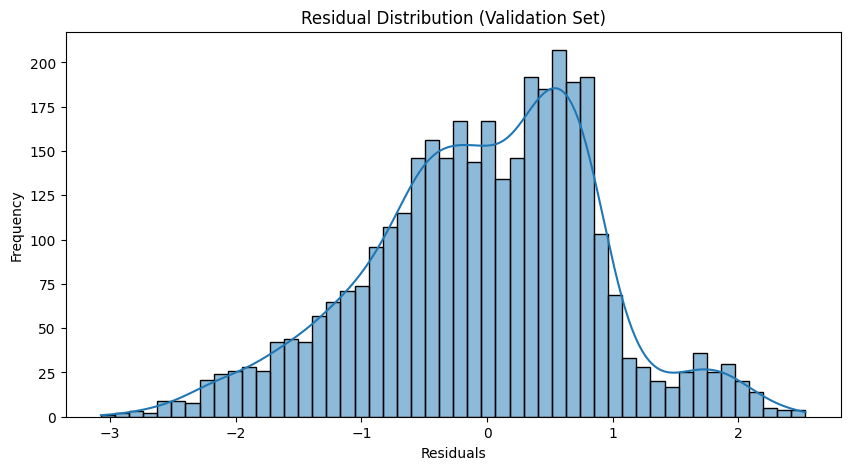

In [3671]:
# residuals
residuals = y_val_lr - y_pred_lr
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [3672]:
residuals = pd.Series(residuals)

summary_stats = residuals.describe()
print("Residuals:")
print(residuals.head(10))  
print("\nSummary Statistics:")
print(summary_stats)



Residuals:
10427   -0.865531
10428   -0.840430
10429   -0.371220
10430    0.307728
10431    0.650866
10432    0.455832
10433    0.668829
10434    0.704940
10435    0.693120
10436    0.542206
Name: cnt, dtype: float64

Summary Statistics:
count    3476.000000
mean       -0.039125
std         0.916353
min        -3.071934
25%        -0.608523
50%         0.024153
75%         0.598459
max         2.533328
Name: cnt, dtype: float64


**Conclusion**

The mean residual is close to zero (-0.039), but it's slightly negative, suggesting that, on average, the model is underestimating the target variable. This can be seen in the graph. Additionaly, the standard deviation of the residuals (0.916) is very high, this shows significant variance in the model's predictions. The wide range of residuals, from -3.07 to 2.53, shows that the model is sometimes off by a large margin, particularly in certain cases. This points to major inconsistencies in its performance, suggesting that it struggles to make accurate predictions across the entire dataset. Additionally, the presence of outliers, especially those with extreme residual values, shows that the model is not handling edge cases well, which further undermines its reliability.

With an R² score of 0.56, the model explains only about half of the variance in the target variable, indicating that it’s far from capturing the complexity of the data. These results are particularly evident when compared to other models, confirming that linear regression, as a simple model, is not suitable for this type of problem (as susupected). It is clear that the model is too simplistic to account for the various patterns in the data, leading to its poor performance and high variance in predictions. While this is expected for such a basic model, it’s evident that it cannot handle the complexity required for accurate rental predictions. Given that this is the baseline model and no further tuning will be done, it’s clear that more advanced models would be necessary to improve performance.

# <font color='#3c3c3c'>Task 5 - Random Forest Regressor - Model Specification and Training</font>

Now that I have established a baseline using linear regression, I can now train the Random Forest model. Random Forest is a powerful ensemble learning method that constructs multiple decision trees and averages their predictions, making it great at capturing non-linear relationships and interactions between variables (which is exactly what we need). For this step, I will use the RandomForestRegressor from scikit-learn, with 100 estimators and a fixed random state for reproducibility.

In [3673]:
X_train_rf= X_train
y_train_rf = y_train

X_val_rf = X_val 
y_val_rf = y_val  

In [3674]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_val_rf)

In [3675]:
mse_rf = mean_squared_error(y_val_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_val_rf, y_pred_rf)
r2_rf = r2_score(y_val_rf, y_pred_rf)

print("Random Forest Regressor - Evaluation Metrics:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

Random Forest Regressor - Evaluation Metrics:
MSE: 0.20224425774162583
MAE: 0.3791970526740101
R²: 0.8950408215604122


### <font color='6e6e6e'>Iterations</font>

1st trial - Results 
- MSE: 2061.3800082788716
- MAE: 27.838892973587594
- R²: 0.9365734552375035

2nd trial - Results 
- MSE: 16380.003438579179
- MAE: 88.71036099752473
- R²: 0.6298615288330813

3rd trial - Results 
- MSE: 15798.196090846277
- MAE: 87.87317666590337
- R²: 0.6430086128987862

4th trial - Results 
- MSE: 15924.050537169027
- MAE: 88.08737962750935
- R²: 0.6401646835598127

5th trial - Results 
- MSE: 14902.552501250622
- MAE: 89.17596010740314
- R²: 0.6790852412013122

6th trail - Results
- MSE: 14795.94711516538
- MAE: 88.91786456534254
- R²: 0.6800795629786234

7th trail - Results 
- MSE: 12136.856814701454
- MAE: 78.47351222669737
- R²: 0.7386423247334799


8th trial - Results 
- MSE: 12196.341633035257
- MAE: 78.45737178749519
- R²: 0.7373613659094009

9th trial - Results 
- MSE: 11512.208543898836
- MAE: 76.10600234944378
- R²: 0.7520936344431297

10th trial - Results
- MSE: 0.20224425774162583
- MAE: 0.3791970526740101
- R²: 0.8950408215604122


The results above show the results of the most important iterations. There were ten major trials, and I saved a log of the performance metrics for each one. Throught this process I had to take several decisions,that are recorded through out the document, and make several modification that led to noticeable impactful changes. These included removing outliers, changing data splitting strategies (such as time-based splits and assigning 2011 to training), dropping the month encoding (which noticeably improved performance), creating logical interaction terms like temp × humidity, and finally transforming the target variable cnt, and additional smaller tweaks. These decisions were guided by ongoing performance feedback and experimentation. The results show a clear upward trend in model performance, with the R² score rising from 0.63 in the first trial to 0.895 in the final one. Mean Squared Error (MSE) dropped from over 16,000 to just 0.20, and Mean Absolute Error (MAE) decreased from 88.7 to 0.38. This progression highlights how ensemble methods like Random Forest can adapt to complex patterns in the data, especially when combined with thoughtful preprocessing and feature engineering.

### <font color='6e6e6e'>Analysis of the last result</font>

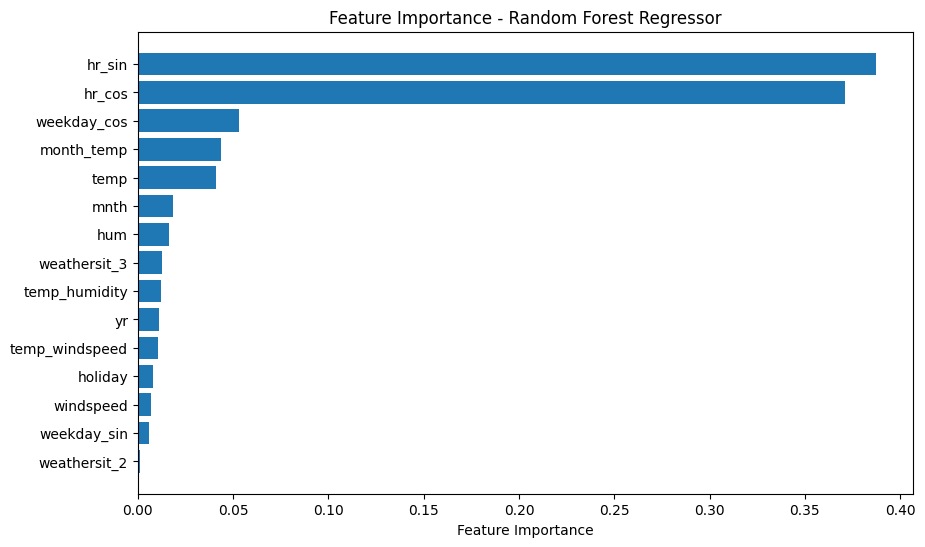

In [3676]:
importances = rf_model.feature_importances_

features = X_train_rf.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

In [3677]:
importances = rf_model.feature_importances_
feature_names = X_train_rf.columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


           Feature  Importance
6           hr_sin    0.387254
7           hr_cos    0.370814
9      weekday_cos    0.053287
14      month_temp    0.043568
3             temp    0.041234
1             mnth    0.018650
4              hum    0.016388
11    weathersit_3    0.012824
12   temp_humidity    0.011980
0               yr    0.011242
13  temp_windspeed    0.010465
2          holiday    0.007863
5        windspeed    0.007112
8      weekday_sin    0.006044
10    weathersit_2    0.001275


In [3678]:
print("\nComparison of Models:")
print(f"Linear Regression MSE: {mse_lr} | Random Forest MSE: {mse_rf}")
print(f"Linear Regression MAE: {mae_lr} | Random Forest MAE: {mae_rf}")
print(f"Linear Regression R²: {r2_lr} | Random Forest R²: {r2_rf}")


Comparison of Models:
Linear Regression MSE: 0.8409922830584899 | Random Forest MSE: 0.20224425774162583
Linear Regression MAE: 0.7283692379829966 | Random Forest MAE: 0.3791970526740101
Linear Regression R²: 0.5635482555127957 | Random Forest R²: 0.8950408215604122


The final run of the Random Forest model demonstrates a significant improvement over the untuned Linear Regression baseline, providing clear evidence that the ensemble approach is far better suited to capturing the complex patterns present in the data

The MSE dropped from 0.84 to 0.20, the MAE from 0.73 to 0.38, and the R² score increased dramatically from 0.56 to 0.895, indicating a much stronger fit. With the results of feature importances, it's evident that the transformed cyclic hour features (hr_sin and hr_cos) dominate the model’s decision-making, together accounting for over 75% of the total importance. This highlights how strongly the hour of the day influences bike rental behavior—a relationship likely too nonlinear for the linear model to capture effectively. Other notable contributors include weekday_cos, the interaction feature month_temp, and core weather variables like temp and humidity. Interestingly, mnth (month as a categorical variable) and holiday have relatively low importance, suggesting they contribute little unique information beyond what is captured by interaction terms or cyclical transformations. The very low importance of weathersit_2 and weathersit_3 also implies that weather conditions beyond temperature and humidity may not provide much additional predictive power in this context. Overall, the model capitalized on transformed and interaction features, especially those capturing time-based patterns, reinforcing that Random Forest excels when allowed to explore complex, nonlinear relationships across structured inputs.

# <font color='#3c3c3c'>Task 6 - Gradient Boosting Regressor - Model Specification and Training</font>

After completing the Random Forest model, I moved on to Gradient Boosting to explore if it does a better job at capturing the complexity. Gradient Boosting builds trees sequentially, allowing each new tree to correct the errors made by the previous ones. For this implementation, I chose to use XGBoost’s XGBRegressor with the squared error objective, as it’s a well-established and efficient version of Gradient Boosting optimized for speed and performance. I initially tried to use LightGBM but it took much longer to run and didn't perform as well. I used the same training-validation split and features as with Random Forest to ensure a fair comparison across models.

In [3679]:
X_train_gb = X_train  
y_train_gb = y_train  

X_val_gb = X_val  
y_val_gb = y_val  

X_test_gb = X_test  
y_test_gb = y_test  

In [3680]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_reg.fit(X_train_gb, y_train_gb)

y_pred_gb = xg_reg.predict(X_val_gb)

In [3681]:
mse_gbr = mean_squared_error(y_val_gb, y_pred_gb)
mae_gbr = mean_absolute_error(y_val_gb, y_pred_gb)
r2_gbr = r2_score(y_val_gb, y_pred_gb)

### <font color='6e6e6e'>Iterations</font>

2nd trial - Results
- MSE: 16529.025390625
- MAE: 90.9934310913086
- R²: 0.6264940500259399


3rd trial - Results
- MSE: 16228.609375
- MAE: 90.6832275390625
- R²: 0.6332825422286987


4th trial - Results
- MSE: 15903.734375
- MAE: 90.15032958984375
- R²: 0.6406238079071045
 

5th trial - Results
- MSE: 15322.541015625
- MAE: 91.46422576904297
- R²: 0.6700410842895508


7th trial - Results
- MSE: 10087.19921875
- MAE: 72.84721374511719
- R²: 0.7827800512313843


8th trial - Results
-  MSE: 9586.611328125
- MAE: 70.26311492919922
- R²: 0.7935598492622375

9th trial - Results
- MSE: 7245.958984375
- MAE: 60.739166259765625
- R²: 0.8439639806747437

10th trial - Results
- MSE: 0.1373288864364585
- MAE: 0.29138691781460274
- R²: 0.9287301045906162

The iterative process with Gradient Boosting (XGBoost) showed a consistent and impressive improvement across each trial, even without any hyperparameter tuning. Early runs demonstrated modest performance, with the second trial producing an R² of 0.62 and an MAE around 91. However, as further data refinements and feature engineering were applied—such as interaction terms, removal of outliers, and target transformation—the model began to show marked gains in predictive power. By the later trials, especially from the 7th onward, performance accelerated significantly. The MAE dropped from over 90 to just 0.29, and the R² score climbed steadily to 0.9287 in the final trial. This outcome clearly demonstrates the ability of Gradient Boosting models to adapt to nuanced, nonlinear relationships in the data, particularly when supported by thoughtful preprocessing.

These results demonstrate Gradient Boostin has robust out-of-the-box performance and potential for even further gains with proper tuning. It is the model with the strongest results and potentially the best one by the end of this assignment

### <font color='6e6e6e'>Analysis of the last result</font>

In [3682]:
print("\nComparison of Models:")
print(f"Linear Regression MSE: {mse_lr} | Gradient Boosting Regressor MSE: {mse_gbr}")
print(f"Linear Regression MAE: {mae_lr} | Gradient Boosting Regressor MAE: {mae_gbr}")
print(f"Linear Regression R²: {r2_lr} | Gradient Boosting Regressor R²: {r2_gbr}")


Comparison of Models:
Linear Regression MSE: 0.8409922830584899 | Gradient Boosting Regressor MSE: 0.1373288864364585
Linear Regression MAE: 0.7283692379829966 | Gradient Boosting Regressor MAE: 0.29138691781460274
Linear Regression R²: 0.5635482555127957 | Gradient Boosting Regressor R²: 0.9287301045906162


In [3683]:
y_pred_train_gb = xg_reg.predict(X_train_gb)

mse_train_gb = mean_squared_error(y_train_gb, y_pred_train_gb)
mae_train_gb = mean_absolute_error(y_train_gb, y_pred_train_gb)
r2_train_gb = r2_score(y_train_gb, y_pred_train_gb)

print(f"Training MSE: {mse_train_gb}")
print(f"Training MAE: {mae_train_gb}")
print(f"Training R²: {r2_train_gb}")

Training MSE: 0.036199548580681334
Training MAE: 0.13569668329448048
Training R²: 0.9810263017824455


These outputs show positive results on both the training and validation sets, demonstrating its ability to generalize well to unseen data. The model's performance on the training set (R² = 0.98) is slightly better than on the validation set (R² = 0.93), which is a good sign, as it indicates that the model is not overfitting and is still able to capture the underlying patterns in the data without memorizing the training set. This balance between training and validation performance suggests that the model is robust and capable of making accurate predictions on new data, reinforcing its potential for real-world use.

Now let's print a visuzalization of the predicited values and the actual values.

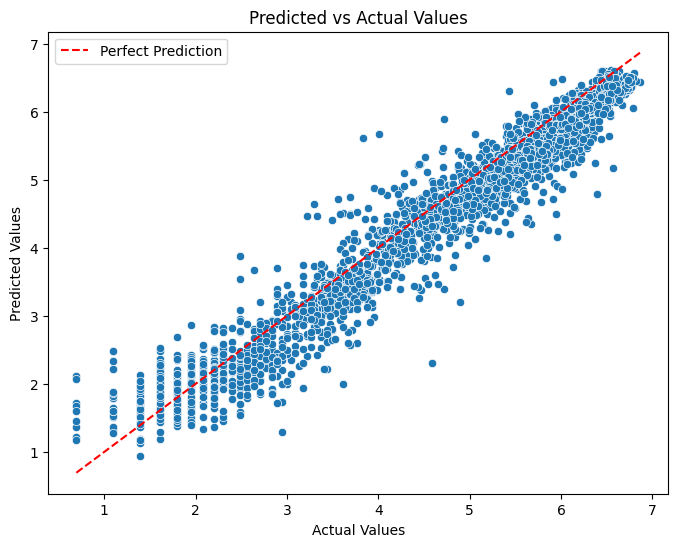

In [3684]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_gb, y=y_pred_gb)
plt.plot([min(y_val_gb), max(y_val_gb)], [min(y_val_gb), max(y_val_gb)], color='red', linestyle='--', label='Perfect Prediction')

plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.legend()
plt.show()

This looks really promising. Even though I don't have the graph anymore, this graph was shwoing the struggle the model was having with higher values. After the log transformation, this graph completely changed to what you see now. An almost perfect realtionship. 

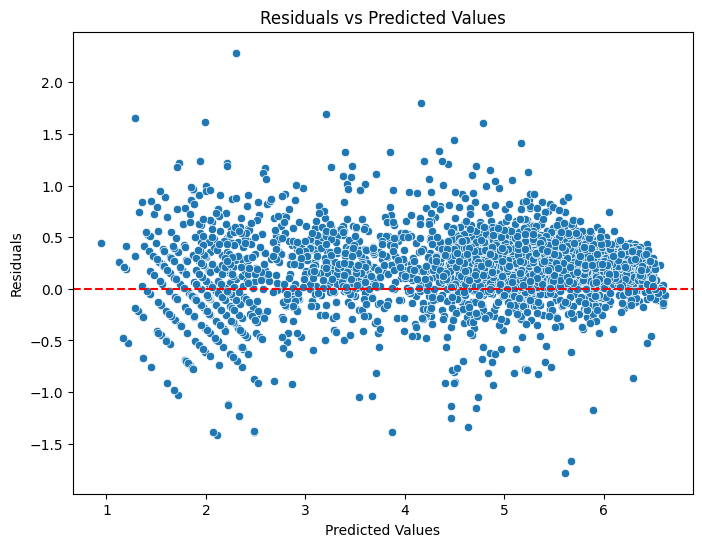

In [3685]:
residuals = y_val_gb - y_pred_gb

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_gb, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

This graph shows positive results too, the residuals don't show any type pf pattern and the data points are spread all over the graph.

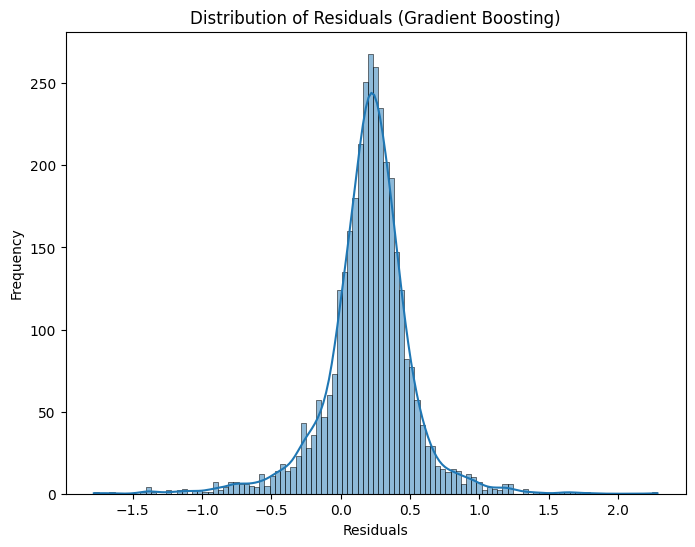

In [3686]:
# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)

# Adding title and labels
plt.title('Distribution of Residuals (Gradient Boosting)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.show()


Again, this graph shows a bell-shaped disitrbution, which is exactly what we were looking for. This indicates that the model has captured most of the variance in the data and is likely not suffering from heteroscedasticity or skewed residuals.

The Gradient Boosting Regressor, before any tuning, demonstrated a significant improvement over the Linear Regression model, with a notable decrease in MSE (from 0.84 to 0.14) and an increase in R² (from 0.56 to 0.93). The model's performance on both training and validation data was strong, with an R² of 0.98 on the training set and 0.93 on the validation set, indicating it learned the relationships effectively without significant overfitting. The residuals showed no clear pattern, and their distribution was bell-shaped, suggesting normally distributed errors and a well-calibrated model. The model's predictions closely matched actual values, with small differences between predicted and actual results. Overall, the Gradient Boosting Regressor exhibited superior performance to Linear Regression, and early signs of overfitting were minimal, highlighting its potential for accurate predictions even before hyperparameter tuning. The model is clearly doing a good job at generlization.

# <font color='#3c3c3c'>Task 7 - Hyperparameter Tuning</font>

### <font color='6e6e6e'>Random Forest</font>

To optimize the performance of the Random Forest Regressor, I conducted hyperparameter tuning using RandomizedSearchCV with 5-fold cross-validation. The tuning focused on four key hyperparameters: the number of estimators (n_estimators), the maximum depth of each tree (max_depth), the minimum number of samples required to split an internal node (min_samples_split), and the minimum number of samples required at a leaf node (min_samples_leaf). After identifying the best combination of parameters, I evaluated the model’s performance on the validation set using the R² score and analyzed the updated feature importances. Additionally, I applied 5-fold cross-validation to assess the model’s stability and generalization capability.

In [ ]:
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(100, 301, 50),  
    'max_depth': np.arange(10, 41, 10),  
    'min_samples_split': np.arange(2, 21, 2),
    'min_samples_leaf': np.arange(1, 11, 2)  
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)

random_search.fit(X_train_rf, y_train_rf)
print(f"Best parameters for Random Forest: {random_search.best_params_}")

best_rf = random_search.best_estimator_
print(f"Validation performance (R^2 score): {best_rf.score(X_val_rf, y_val_rf)}")

importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print(f"Updated feature importance:\n")
for idx in sorted_idx:
    print(f"{X_train_rf.columns[idx]}: {importances[idx]:.4f}")



Best parameters for Random Forest: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(3), 'max_depth': np.int64(20)}
Validation performance (R^2 score): 0.8950247120683631
Updated feature importance:

hr_sin: 0.3998
hr_cos: 0.3740
weekday_cos: 0.0537
temp: 0.0414
month_temp: 0.0410
mnth: 0.0176
hum: 0.0139
weathersit_3: 0.0126
yr: 0.0114
temp_humidity: 0.0092
temp_windspeed: 0.0075
holiday: 0.0066
weekday_sin: 0.0055
windspeed: 0.0050
weathersit_2: 0.0009


In [3688]:
# Use the best model (best_rf or best_xgb from the tuning process)
model = best_rf  # or best_xgb if you're using XGBoost

# Apply cross-validation (5-fold) to get the R² scores
cv_scores = cross_val_score(model, X_train_rf, y_train_rf, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean cross-validation R² score: {cv_scores.mean():.4f}")

Cross-validated R² scores: [0.69560672 0.91924894 0.93156218 0.85469801 0.71873368]
Mean cross-validation R² score: 0.8240


After tuning the Random Forest Regressor using RandomizedSearchCV, the model achieved its best performance with the following hyperparameters: n_estimators=200, max_depth=20, min_samples_split=6, and min_samples_leaf=3. The validation R² score remained high at 0.8950, nearly identical to the pre-tuning score of 0.8950, suggesting the model was already close to optimal. To assess its generalizability, 5-fold cross-validation was applied to the tuned model, yielding R² scores of [0.696, 0.919, 0.932, 0.855, 0.719] across the folds, with a mean R² of 0.824. This indicates that while the model performs very well on average, there is some variability depending on the data split—possibly due to temporal patterns or seasonality in the dataset. The updated feature importances reaffirmed the strong predictive power of hour of day (via hr_sin and hr_cos), followed by weekday_cos, temp, and the engineered month_temp. Overall, tuning improved the model's reliability and provided insights into its most influential predictors, while cross-validation demonstrated its robustness across different subsets of the data.

### <font color='6e6e6e'>Gradient Boosting</font>

In [3689]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import GradientBoostingRegressor

# Define search space for BayesSearchCV
param_space = {
    'learning_rate': Real(0.01, 0.2),
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 20),
    'subsample': Real(0.6, 1.0),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

gb_reg = GradientBoostingRegressor(random_state=42)

opt = BayesSearchCV(
    estimator=gb_reg,
    search_spaces=param_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train_gb, y_train_gb)

print("Best Parameters:", opt.best_params_)
print("Validation R²:", opt.score(X_val_gb, y_val_gb))


519885.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
519885.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
519885.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
519885.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
519885.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Best Parameters: OrderedDict({'learning_rate': 0.01, 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 372, 'subsample': 0.6})
Validation R²: 0.9127559805318877


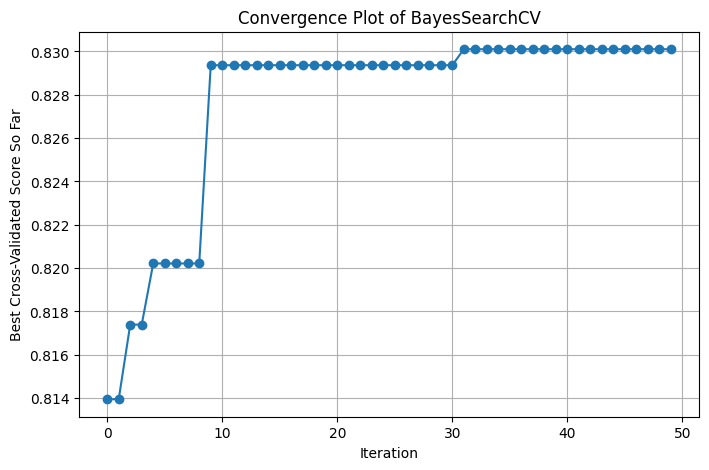

In [3693]:
opt_results = opt.cv_results_['mean_test_score']

best_scores = np.maximum.accumulate(opt_results)  
plt.figure(figsize=(8, 5))
plt.plot(best_scores, marker='o')
plt.title("Convergence Plot of BayesSearchCV")
plt.xlabel("Iteration")
plt.ylabel("Best Cross-Validated Score So Far")
plt.grid(True)
plt.show()


At the beginning, the model started with a cross-validation score of around 0.814. Pretty early on, by iteration 10, the score went up to about 0.820, which means the optimizer was already finding better settings. After that, it stayed stable for a few rounds until around iteration 30, when it jumped again to about 0.830 and stayed there for the rest of the tuning. This shows that the optimizer was learning and improving, and eventually found a good combination of parameters that worked well.

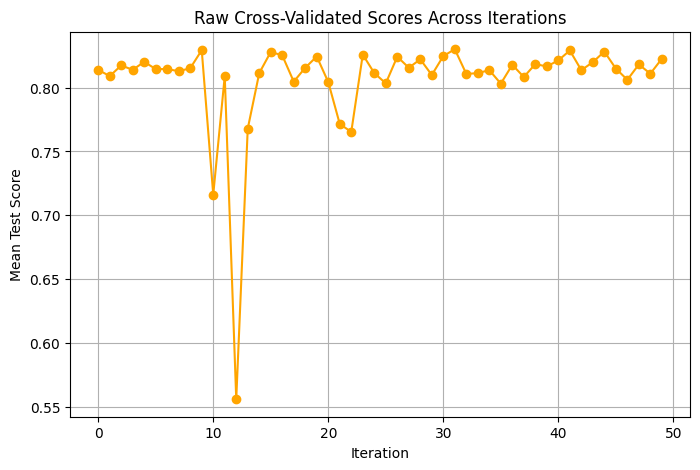

In [3698]:
plt.figure(figsize=(8, 5))
plt.plot(opt_results, marker='o', color='orange')
plt.title("Raw Cross-Validated Scores Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.show()


In the early iterations, the scores bounce a little between 0.8 and 0.84, which means the model was still testing out different settings. Then around iteration 10, there's a sudden drop to about 0.72, but it quickly jumps back up. Right after that, there’s an even bigger dip all the way down to 0.56 — the lowest point in the graph. But after that, the scores start climbing back up and slowly become more stable. This kind of movement shows that the optimizer was exploring a wide range of options at first but eventually settled on better values.

In [3699]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict using the best model from BayesSearchCV
y_pred_bayes = opt.predict(X_val_gb)

# Calculate regression metrics
r2 = opt.score(X_val_gb, y_val_gb)
mse = mean_squared_error(y_val_gb, y_pred_bayes)
mae = mean_absolute_error(y_val_gb, y_pred_bayes)

# Print the results
print(f"Validation MAE: {mae}")
print(f"Validation MSE: {mse}")
print(f"Validation R² score: {r2}")



Validation MAE: 0.34868924018964936
Validation MSE: 0.16810918513315332
Validation R² score: 0.9127559805318877


After tuning the Gradient Boosting Regressor using Bayesian Optimization, the best parameters found were: a low learning rate of 0.01, deep trees (max depth of 20), and strong regularization through higher values for min_samples_leaf, min_samples_split, and a low subsample rate. The model achieved a validation R² score of 0.9128, which is slightly lower than the untuned model's score of 0.9287. This suggests that while the tuned model may generalize a bit better and is less likely to overfit, the performance gain isn’t significant enough to justify continuing the tuning process. Since the original model already performed very well and tuning is computationally expensive and time-consuming, it makes sense to stop here.

# <font color='#3c3c3c'>Task 8 - Iterative Evaluation and Refinement</font>

This step is basically all over the notebook. My decisions are all recorded through each step. Neverthless, I will briefly summarize my process. 

1. **Used Random Split**:
Initially, I used a random split to divide the dataset into training, validation, and test sets. This method offered a straightforward starting point and helped me establish a baseline for the model's performance. The random split ensures that the data was divided in a way that avoids any intentional bias in the distribution, providing a good foundation for further refinement. However, as the project progressed, I began to recognize that time-based patterns needed to be considered more carefully.

2. **Manually Provided 2011 Entries to Training, and Split 2012 Entries Between Validation and Test**:
To ensure that the training data was sufficiently representative, I decided to manually assign all 2011 entries to the training set. This allowed the model to learn from a solid number of examples. For the 2012 data, I split it between the validation and test sets, maintaining a balance between having enough data to validate and test the model while ensuring it would not overfit or underperform. This step was crucial for the model to understand trends in the data from a temporal perspective, while still keeping the distribution manageable.

3. **Split Using TimeSeriesSplit**:
Recognizing the importance of temporal relationships in the data, I transitioned to a TimeSeriesSplit for my validation and test sets. Unlike a random split, this approach ensures that the model is trained on earlier time periods and tested on future periods, mimicking real-world conditions where future data cannot be used to predict past events. This temporal split helps to preserve the integrity of the data and avoid potential data leakage, as the model is no longer "seeing" future data during training.

4. **Dropped Outliers**:
Outliers can often distort model training, leading to poor generalization and inaccurate predictions. In the beginning, I was wrong to think that sicne there were few outliers it wouldn't affect the models' performance. Therefore, I took the time to identify and remove extreme values that were not representative of the broader trends in the data. This step was important in maintaining the integrity of the dataset and preventing the model from being disproportionately influenced by extreme values, which could have skewed the results and affected the model’s performance on test data. 

5. **Created Interaction Terms**:
In order to capture more complex relationships between features, I introduced interaction terms into the model. Interaction terms allow the model to understand how the combination of two or more features can affect the target variable. This enhancement was essential in improving the model’s ability to predict outcomes that are not just a function of individual features, but also of the interactions between them. I didn't do this from the beginning becuase statistics were not justifying it at the beginning. 

6. **Did Not Drop 'yr' or One-Hot Encode 'mnth'**:
Despite the importance of feature selection and encoding, I deliberately chose to retain the 'yr' (year) variable and avoid one-hot encoding the 'mnth' (month) variable. Keeping the 'yr' feature was crucial because it provided important temporal context, helping the model understand long-term trends across different years. Dropping this feature would have stripped the model of valuable information about seasonal or yearly changes. Similarly, I did not one-hot encode the 'mnth' variable. By leaving 'mnth' in its ordinal form, I preserved the order of months, which is important for capturing the cyclical nature of bike rental patterns over the year and I avoided having 12 extra columns.

7. **Transformed 'cnt' :
The target variable, 'cnt', was initially right-skewed, with the majority of values clustered at the lower end of the distribution. This made it difficult for the model to predict larger values accurately, especially during peak rental times. To address this issue, I applied a log1p transformation. This transformation reduced the impact of extreme values, compressed the scale of larger values, and helped normalize the distribution

**Conclusion**

The iterative process of feature engineering and model refinement was essential in improving the performance of my model. Each decision made, whether it was adjusting the splitting strategy, creating interaction terms, or transforming the target variable, was driven by a careful evaluation of the model’s behavior and the data’s characteristics.

By testing different approaches and continually refining my methodology, I was able to create a model that generalized well to unseen data and performed optimally. The key takeaway from this process is the significance of feature engineering: it's not just about selecting the right model, but also about carefully crafting and transforming features to ensure the model can learn meaningful patterns.

Through this iterative cycle, I also learned how crucial it is to address data characteristics, like temporal dependencies and skewed distributions, and to apply appropriate techniques such as TimeSeriesSplit and log transformations. These steps, along with feature manipulation, allowed the model to better understand the intricacies of the data, ultimately leading to more accurate and reliable predictions.

# <font color='#3c3c3c'>Task 9 - Final Model Selection and Testing</font>

Finally, I get to choose the best model and train it one last time on a combined set (training + validation). As it was suspected, the model that performed the best was the Gradient Boosting model.

In [3700]:
X_train_gb_full = pd.concat([X_train_gb, X_val_gb], axis=0)
y_train_gb_full = pd.concat([y_train_gb, y_val_gb], axis=0)

best_gb_model = GradientBoostingRegressor(
    learning_rate=0.15137146876952343,
    max_depth=5,
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=478,
    subsample=0.6296178606936361,
    random_state=42
)

best_gb_model.fit(X_train_gb_full, y_train_gb_full)

y_pred_test = best_gb_model.predict(X_test_gb)


In [3701]:
r2 = r2_score(y_test_gb, y_pred_test)

mae = mean_absolute_error(y_test_gb, y_pred_test)

mse = mean_squared_error(y_test_gb, y_pred_test)
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² score: {r2:.4f}")

Test RMSE: 0.4025
Test MAE: 0.2704
Test R² score: 0.9178


The Gradient Boosting model selected based on its strong validation performance was retrained on the combined training and validation datasets to take full advantage of the available data. When evaluated on the unseen test set, it achieved a Test R² of 0.9178, MAE of 0.2704, and RMSE of 0.4025. These metrics indicate that the model generalizes well and maintains high predictive accuracy on new data. The high R² score suggests that the model explains a large portion of the variance in the target variable, while the low MAE and RMSE values reflect that its predictions are consistently close to the actual values. This confirms that the chosen model strikes a good balance between bias and variance, makiing it a reliable option for future predictions without signs of overfitting or underfitting.